In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [7]:
#===========================================================
# File Name : B_DA_RETL_CHURN MODEL                           
# Description :                                             
# Date : 2020-11-12                                         
# Writer : Yoon Jun Beom
# Packages :                                                
# Note :                           
#===========================================================

# Data Preprocessing

In [8]:
# library import 
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [13]:
# 가맹점 별 운영정보 데이터
base = pd.read_csv(r"..\..\b_da_retl_churn_anl_md_tmp_table.csv")
base.drop("레코드 수", axis= 1, inplace = True)

base = base[['reg_no','amt_day_cnt', 'avg_amt', 'avg_cnt', 'avg_mm_amt', 'avg_mm_cnt',
       'bf_month_diff_amt', 'bf_month_diff_cnt', 'churn_yn', 'high_lw_term',
       'join_term', 'last_xmit_date', 'm3_sd_amt', 'm3_sd_cnt', 'm_00_app_amt',
       'm_00_app_cnt', 'm_01_app_amt', 'm_01_app_cnt', 'm_02_app_amt',
       'm_02_app_cnt', 'm_03_app_amt', 'm_03_app_cnt', 'm_04_app_amt',
       'm_04_app_cnt', 'm_05_app_amt', 'm_05_app_cnt', 'max_amt_month',
       'min_amt_month', 'min_mm_amt', 'min_mm_cnt', 'min_xmit_date',
       'month_cnt', 'mx_mm_amt', 'mx_mm_cnt', 'mx_xmit_date', 
       'sd_amt', 'sd_mm_amt', 'sd_mm_cnt', 'sum_amt', 'sum_cnt',
       'wk2_amt_diff', 'wk2_cnt_diff']]

In [14]:
# 가맹점코드 매핑, 분류 조정
map_code_info = pd.read_csv(r"..\..\b_svr_map_code_info.csv")
map_code_info.drop(['레코드 수', 'load_dtm'], axis = 1, inplace = True)

li = [ 
["부페", "중식", "퓨전/기타음식점", "한식-일반음식점", "양식", "일식/수산물", "분식/휴게음식점", "패스트푸드/제과점"]	, "음식점" ,
["실내스포츠시설운영업", "실외스포츠시설운영업", "스포츠시설운영업"]	, "스포츠시설운영업",
["예체능계학원", "외국어학원", "일반교과학원", "기타학원", "학습지/코칭교육"]	, "학원",
["자동차및부품판매점", "자동차정비/세차/주차장"]	, "자동차관련판매점",
["유흥주점-무도/가무", "일반유흥주점"]	, "주점",
["독서실/도서관"]	, "기타시설운영업",
["세탁/가사/전문서비스", "주택수리서비스", "용품수리서비스"]	, "대행/용역/인력알선",
["약국/한약방", "유사의료업", "의료관련서비스업"]	, "병원",
["예식/의례/관혼상제"]	, "수의업"
]    
a = []  
b = []

for i in li:
    if type(i) == list :
        a.append(i)
    else :
        b.append(i)
        
for i, j in zip(a, b):
    map_code_info['cd_lv2_nm'].replace(i, j, inplace= True)        

In [19]:
# 가맹점 정보 매핑
debit_retl = pd.read_csv(r"..\..\debit_retl.csv", dtype='str')

In [20]:
debit_retl = debit_retl[['reg_no','h_code','dbr_new_svr_code']]
map_code_info = map_code_info[['map_cd','map_gubun','cd_lv2_nm']]
debit_retl = debit_retl.merge(map_code_info.query("map_gubun == 'V'"), 'left', left_on= 'dbr_new_svr_code', right_on = 'map_cd')

In [21]:
month_tot = base.copy()

In [22]:
month_tot['reg_no'] = month_tot.reg_no.astype("str")

In [23]:
# Feature engineering (비중)
for i in range(6):
    month_tot[f'm{str(i+1)}_cnt_rto'] = month_tot[f'm_{str(i).zfill(2)}_app_cnt'] / month_tot['sum_cnt'] 
    month_tot[f'm{str(i+1)}_amt_rto'] = month_tot[f'm_{str(i).zfill(2)}_app_amt'] / month_tot['sum_amt'] 

# MoM (전월 대비 증감율)
for i in range(5):        
    month_tot[f'm{str(i).zfill(2)}_cnt_updn_rto'] = (month_tot[f'm_{str(i).zfill(2)}_app_cnt'] / month_tot[f'm_{str(i+1).zfill(2)}_app_cnt']) -1 
    month_tot[f'm{str(i).zfill(2)}_amt_updn_rto'] = (month_tot[f'm_{str(i).zfill(2)}_app_amt'] / month_tot[f'm_{str(i+1).zfill(2)}_app_amt']) -1 

In [24]:
month_tot.replace([np.inf, -np.inf], np.nan, inplace = True)

In [25]:
for col in month_tot.columns : # [month_tot.columns.str.contains(r"(_rto)")]
    if month_tot[col].dtype == 'object': 
        pass 
    month_tot.fillna({col:0}, inplace = True)

month_tot['avg_cnt_updn_rto'] = month_tot[month_tot.columns[month_tot.columns.str.contains(r"(_cnt_updn_rto)")]].mean(1)
month_tot['avg_amt_updn_rto'] = month_tot[month_tot.columns[month_tot.columns.str.contains(r"(_amt_updn_rto)")]].mean(1)

base_tot = month_tot.merge(debit_retl[['reg_no','cd_lv2_nm']], 'inner', on = 'reg_no')

base_tot = base_tot[base_tot.cd_lv2_nm.notna()]

In [26]:
# 운영했던 일자 수
base_tot['norm_wrk_day'] = \
pd.to_datetime(base_tot.mx_xmit_date, format = "%Y%m%d") - pd.to_datetime(base_tot.min_xmit_date, format = "%Y%m%d") + np.timedelta64(1, 'D')
base_tot['norm_wrk_day'] = base_tot.norm_wrk_day / np.timedelta64(1, 'D')

In [27]:
# 매출일 수 / 운영일 수
base_tot['amt_day_rto'] = base_tot.amt_day_cnt / base_tot.norm_wrk_day

In [28]:
reg_churn_model = base_tot.drop(["mx_xmit_date", "last_xmit_date","min_xmit_date", "norm_wrk_day", "amt_day_cnt",
                      "min_mm_amt", "mx_mm_amt", "max_amt_month", "min_amt_month", "mx_mm_cnt", "min_mm_cnt"], axis = 1)

# Build Model

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

In [30]:
reg_churn_model['churn_yn'] = reg_churn_model.churn_yn.factorize()[0]
reg_churn_model['cd_lv2_nm'] = reg_churn_model.cd_lv2_nm.factorize()[0]

y = reg_churn_model['churn_yn'].values
X = reg_churn_model.drop(['reg_no','churn_yn'], axis = 1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [30]:
m = round(np.sqrt(len(reg_churn_model.drop(['reg_no','churn_yn'], axis = 1).columns)),0)

In [31]:
rf = RandomForestClassifier(n_estimators=100, max_depth= 16, random_state=1)

In [32]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [33]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'.format(accuracy_score(y_test, y_pred.round())))

Model accuracy score with 10 decision-trees : 0.9569


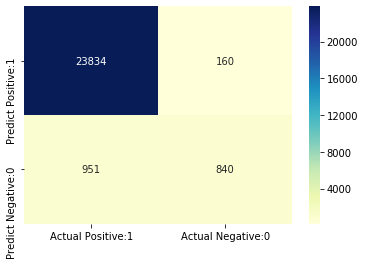

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred.round())
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# Select Cutoff (0.35)

In [36]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score

In [37]:
# 이탈 가맹점: 약 6.7%
print(reg_churn_model.churn_yn.value_counts())
print(reg_churn_model.churn_yn.value_counts() / reg_churn_model.churn_yn.value_counts().sum())

0    80149
1     5798
Name: churn_yn, dtype: int64
0    0.93254
1    0.06746
Name: churn_yn, dtype: float64


In [38]:
# find cut off
y_prob = rf.predict_proba(X_test)
i = 0.3
data = []
while True : 
    if i > 0.9 :
        break
    y_pred = (y_prob[:,1] >= i).astype("int")
    data.append([i,accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred),f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)])
    i = i + 0.05

In [39]:
result = pd.DataFrame(data)
result.columns = ['cutoff','accuracy', 'precision','recall', 'f1_score', 'roc_auc_score']
result # 0.35 

,cutoff,accuracy,precision,recall,f1_score,roc_auc_score
0,0.30,0.949118,0.608322,0.750977,0.672164,0.857442
1,0.35,0.953927,0.661662,0.689001,0.675055,0.831351
2,0.40,0.957107,0.718014,0.629816,0.671029,0.805676
3,0.45,0.957262,0.774502,0.542714,0.638214,0.765459
4,0.50,0.956913,0.840000,0.469012,0.601935,0.731172
5,0.55,0.955090,0.894147,0.400893,0.553585,0.698675
6,0.60,0.952298,0.950241,0.330542,0.490472,0.664625
7,0.65,0.948342,0.959920,0.267448,0.418341,0.633307
8,0.70,0.944347,0.973404,0.204355,0.337794,0.601969
9,0.75,0.941012,0.989130,0.152429,0.264151,0.576152


# K-fold test (k = 3)
##### stratified k-fold cross-validation (shuffle)

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

In [41]:
skf = StratifiedShuffleSplit(n_splits=3)

In [42]:
rf = RandomForestClassifier(n_estimators=50, random_state=1)

In [43]:
for idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_test)
    y_pred = (y_prob[:,1] >= 0.35).astype("int")
    print(f"______________{idx}______________") 
    print(f"accuracy_score : {accuracy_score(y_test, y_pred):0.4f}")
    print(f"f1_score : {f1_score(y_test, y_pred):0.4f}")
    print(f"precision_score : {precision_score(y_test, y_pred):0.4f}")
    print(f"recall_score : {recall_score(y_test, y_pred):0.4f}")
    print(f"_______________________________") 

______________0______________
accuracy_score : 0.9521
f1_score : 0.6584
precision_score : 0.6342
recall_score : 0.6845
_______________________________
______________1______________
accuracy_score : 0.9567
f1_score : 0.6921
precision_score : 0.6656
recall_score : 0.7207
_______________________________
______________2______________
accuracy_score : 0.9539
f1_score : 0.6689
precision_score : 0.6494
recall_score : 0.6897
_______________________________


# Parameter Select 
#### GridSearch

In [44]:
from sklearn.model_selection import GridSearchCV

In [50]:
param_grid = {
    'max_depth': [5,6,7,8,9,10,14,16,18], # sqrt(d), log2(d)
    'n_estimators': [10, 50, 100],
}

In [51]:
estimator = RandomForestClassifier()

In [52]:
skf = StratifiedShuffleSplit(n_splits=3)

In [53]:
grid_search = GridSearchCV(estimator = estimator, 
                           param_grid = param_grid, 
                           cv = skf,
                           n_jobs = -1)

# fit with (x_train, y_train)
grid_search.fit(X, y)
print(f"best_parameter : {grid_search.best_params_}")

best_parameter : {'max_depth': 16, 'n_estimators': 100}


In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
for idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    best_model.fit(X_train, y_train)
    y_prob = best_model.predict_proba(X_test)
    y_pred = (y_prob[:,1] >= 0.35).astype("int")
    print(f"______________{idx}______________") 
    print(f"accuracy_score : {accuracy_score(y_test, y_pred):0.4f}")
    print(f"f1_score : {f1_score(y_test, y_pred):0.4f}")
    print(f"precision_score : {precision_score(y_test, y_pred):0.4f}")
    print(f"recall_score : {recall_score(y_test, y_pred):0.4f}")
    print(f"_______________________________") 

# Feature importance

In [54]:
# best_model.feature_importances_
feature_scores = pd.Series(best_model.feature_importances_, index=reg_churn_model.drop(['reg_no','churn_yn'], axis = 1).columns).sort_values(ascending=False)

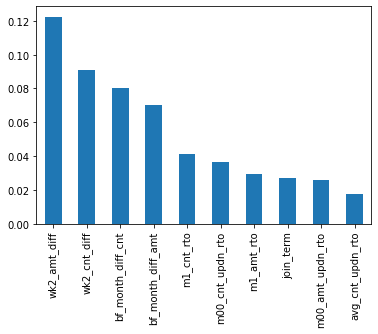

In [62]:
# 최근 2주간의 amt, cmt '변화' 
# 전월 대비 amt, cnt 변화
# 그 밖에 6개월 sum cnt 중에서 차지하는 비율 등 바로 직전 기간의 가맹점 실적이 중요한 변수로 보여짐
feature_scores[:10].plot(kind = 'bar')

In [44]:
rf.fit(X, y)

RandomForestClassifier(n_estimators=50, random_state=1)

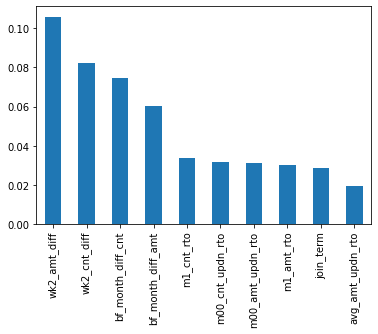

In [45]:
feature_scores = pd.Series(rf.feature_importances_, index=reg_churn_model.drop(['reg_no','churn_yn'], axis = 1).columns).sort_values(ascending=False)
feature_scores[:10].plot(kind = 'bar')

In [48]:
feature_scores[:10].reset_index()

,index,0
0,wk2_amt_diff,0.106048
1,wk2_cnt_diff,0.082195
2,bf_month_diff_cnt,0.074827
3,bf_month_diff_amt,0.060078
4,m1_cnt_rto,0.033834
5,m00_cnt_updn_rto,0.031366
6,m00_amt_updn_rto,0.031181
7,m1_amt_rto,0.030113
8,join_term,0.028505
9,avg_amt_updn_rto,0.019165


In [52]:
import matplotlib.pyplot as plt

In [54]:
plt.rcParams['font.family'] = 'NanumSquare'
plt.rcParams['figure.figsize'] = (15,7)

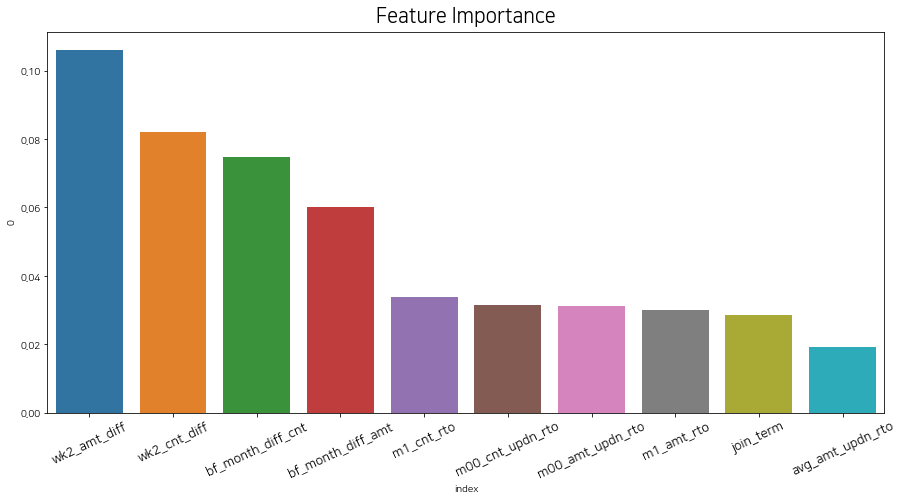

In [55]:
fig = plt.figure(figsize=(15,7))
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=10) 
sns.barplot(x='index', y=0, data= feature_scores[:10].reset_index())

plt.xticks(rotation=25)
plt.title('Feature Importance', fontsize=20, pad = 10)
plt.savefig('feature_importance.png', dpi=200, facecolor=fig.get_facecolor(), bbox_inches='tight'
)

# Save Model

In [63]:
import joblib

In [67]:
joblib.dump(best_model, 'churn_model.pkl')

['churn_model.pkl']

In [ ]:
feature_scores[:10].plot(kind = 'bar')